Use the CSIRO-Mk3-6-0 10 member ensemble to look into the dependence of model responce uncertainty on the LOWESS window size.

### Define some functions

In [2]:
def lowess(window, yy):
    """Fit a LOWESS filter for a given window size"""
    return sm.nonparametric.lowess(
        endog=yy,
        exog=np.arange(len(yy)),
        frac=float(window) / float(len(yy)),
        it=0,
        delta=0.,
        is_sorted=True,
        missing='raise',
        return_sorted=False,)

def fit_lowess(window, ds, varn):
    data = []
    for season in ds.season_id:
        dd = ds.sel(season_id=season)[varn].data
        ll = lowess(window, dd)
        data.append(ll)
    ds['{}_lowess'.format(varn)] = xr.DataArray(data, dims=('season_id', 'time'))

### Import CSIRO-Mk3 (10 ensemble members)

In [3]:
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import xarray as xr
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/lukbrunn/Documents/Scripts/utils')

from get_filenames import Filenames

varns = ['tas', 'pr']
scenarios = ['rcp26', 'rcp45', 'rcp85']

fn = Filenames('{varn}/{varn}_sea_CSIRO-Mk3-6-0_{scenario}_{ensemble}_g025.nc')
fn.apply_filter(varn=varns, scenario=scenarios)

ds_varns = []
for varn in varns:
    ds_scen = []
    for scenario in scenarios:
        filenames = fn.get_filenames(subset={'varn': varn, 'scenario': scenario})
        ds_ens = []
        for filename in filenames:
            ds = xr.open_dataset(filename)
            ds = ds.sel(season_id=[0, 6]).mean(('lat', 'lon'))
            ds['time'].data = ds['time'].dt.year
            del ds['time'].encoding['units']
            
            # fit_lowess(200, ds, varn)  # HERE
            
            ds_ens.append(ds)
        ds = xr.concat(ds_ens, dim='ensemble')
        ds['scenario'] = xr.DataArray([scenario], dims='scenario')
        ds_scen.append(ds)
    ds = xr.concat(ds_scen, dim='scenario')
    ds_varns.append(ds)
ds = xr.merge(ds_varns)
ds.to_netcdf('/net/h2o/climphys/lukbrunn/Data/IsolateNaturalVariability/{}_sea_CSIRO-Mk3-6-0_{}_g025.nc'.format(
    '-'.join(varns), '-'.join(scenarios)), mode='w')


/home/lukbrunn/.conda/envs/my_p3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Example plot for different window sizes (RCPs, seasons, variables)

In [4]:
# need to run this once
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

Populating the interactive namespace from numpy and matplotlib


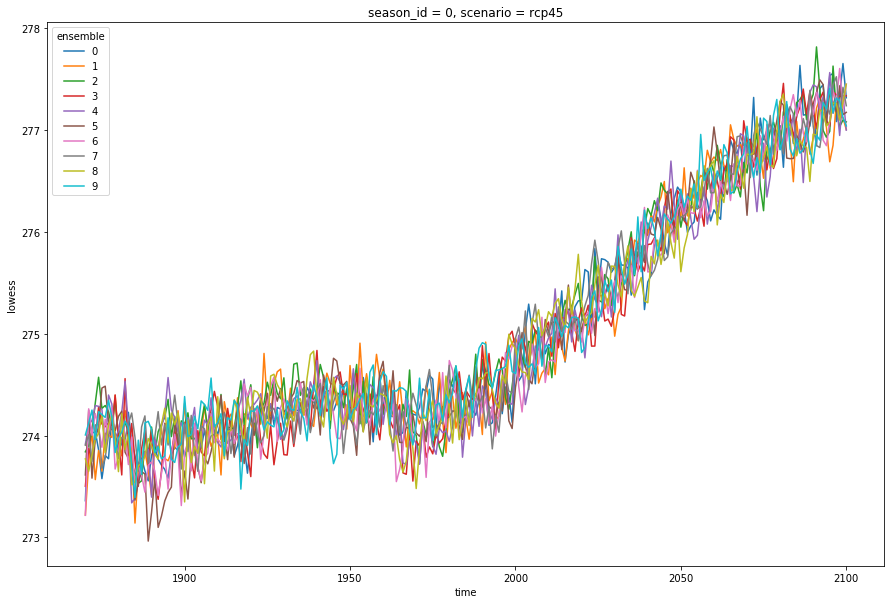

In [5]:
# user input
scenario = 'rcp45'
season = 0
varn = 'tas'
window = 3

ds_sel = ds.sel(scenario=scenario).sel(season_id=season)
_ = ds_sel[varn].plot.line(x='time')
plt.show()

dss = []
for ensemble in ds_sel.ensemble:
    ds_ssel = ds_sel.sel(ensemble=ensemble)
    ds_ssel['lowess'] = xr.DataArray(lowess(window, ds_ssel[varn].data), dims='time') 
    dss.append(ds_ssel)
ds_sel = xr.concat(dss, dim='ensemble')
_ = ds_sel['lowess'].plot.line(x='time')


#### In general the variance becomes smaller the larger the window size becomes

In [6]:
windows = list(range(3, 21, 2)) + list(range(21, 202, 10))
scenario = 'rcp85'
season = 6
varn = 'tas'

variances = []
for window in windows:
    ds_sel = ds.sel(scenario=scenario).sel(season_id=season)
    dss = []
    for ensemble in ds_sel.ensemble:
        ds_ssel = ds_sel.sel(ensemble=ensemble)
        ds_ssel['lowess'] = xr.DataArray(lowess(window, ds_ssel[varn].data), dims='time')
        dss.append(ds_ssel)
    ds_sel = xr.concat(dss, dim='ensemble')
    var = ds_sel.sel(time=slice(2005, None))['lowess'].var('ensemble').mean('time')
    variances.append(var)

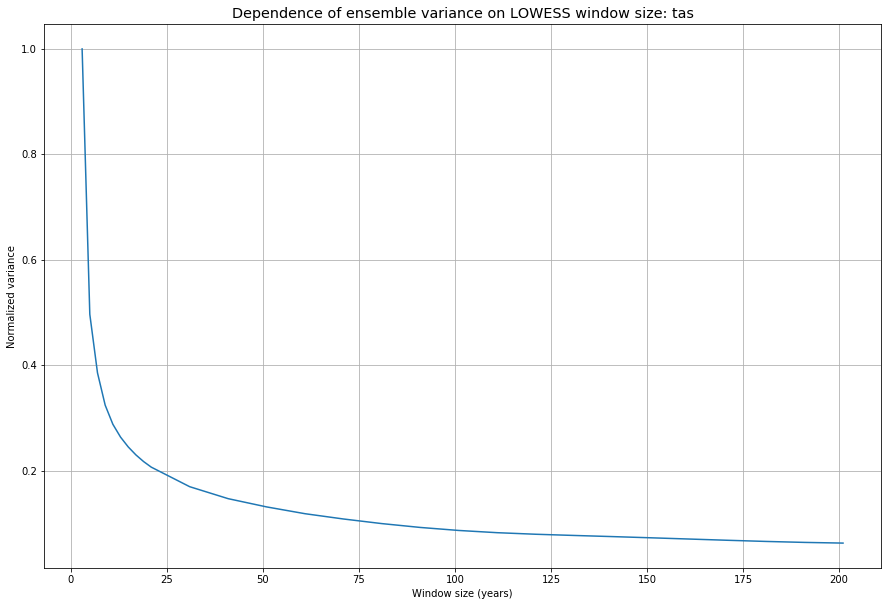

In [7]:
plt.plot(windows, variances / np.max(variances))
plt.gca().set_ylabel('Normalized variance')
plt.gca().set_xlabel('Window size (years)')
plt.gca().set_title('Dependence of ensemble variance on LOWESS window size: {}'.format(varn), fontsize='x-large')
plt.grid(True)
plt.show()